In [19]:
import pickle
import pandas as pd

# Specify the path to your pickle file
pickle_file = "processed_voxel_data.local/all_datasets_voxel_data.pkl"

# Load the data
with open(pickle_file, "rb") as f:
    data = pickle.load(f)

In [24]:
print("Metadata:", data['metadata'])
print("Number of voxel entries:", len(data['voxel_data']))

# Convert voxel data to a DataFrame
voxel_df = pd.DataFrame(data['voxel_data'])

voxel_df.head()


Metadata: {'voxel_size': 1, 'min_num_points': 20, 'min_proportion': 1.0, 'datasets': ['flight', 'siegertsbrunn', 'garching', 'aying_hills', 'aying_mangfall', 'garching_2', 'neubiberg_rain', 'neubiberg_sunny']}
Number of voxel entries: 914150


,dataset,voxel_key,center_x,center_y,num_points,dominant_label,dominant_proportion,RMSE,plane_coefficients,convex_hull_volume,...,elevation_range,avg_intensity,std_intensity,lbp,variance_ratios,flatness,elongation,height_variability,vertical_skewness,mean_nn_distance
0,flight,"(-2, -1)",-1.5,-0.5,195,8,1.0,0.056544,"[-0.5379800133475481, -0.076032829749107, 0.83...",0.014004,...,0.213960,32.230770,19.850546,63,"[0.8110946, 0.11931115, 0.0695943]",1.714381,6.798146,0.063482,1.040636,0.010986
1,flight,"(-7, -1)",-6.5,-0.5,41,23,1.0,0.001638,"[-0.2587742154996574, -0.020896474074129392, 0...",0.000138,...,0.018769,8.682927,2.654394,47,"[0.99766487, 0.0022945271, 4.0627376e-05]",56.477364,434.801941,0.004320,-0.099635,0.026620
2,flight,"(-9, -1)",-8.5,-0.5,31,23,1.0,0.000978,"[-0.20376935366423798, -0.015933593684945773, ...",0.000041,...,0.015475,22.645161,2.546957,6,"[0.99913657, 0.0008434792, 1.9878838e-05]",42.431011,1184.542114,0.004446,0.195151,0.031340
3,flight,"(-14, -2)",-13.5,-1.5,20,23,1.0,0.000501,"[-0.1782574389317535, -0.01940379690967842, 0....",0.000042,...,0.017959,17.299999,6.581033,26,"[0.99594706, 0.004050056, 2.8698332e-06]",1411.251343,245.909454,0.003422,1.651364,0.039707
4,flight,"(-74, -9)",-73.5,-8.5,71,17,1.0,0.241573,"[-0.9385063353588649, -0.3451441303377067, 0.0...",2.848048,...,4.862710,29.535212,14.187706,31,"[0.92849207, 0.044884995, 0.026622893]",1.685955,20.686024,1.444229,-0.370318,0.234385


In [26]:
voxel_df.keys()

Index(['dataset', 'voxel_key', 'center_x', 'center_y', 'num_points',
       'dominant_label', 'dominant_proportion', 'RMSE', 'plane_coefficients',
       'convex_hull_volume', 'density', 'elevation_range', 'avg_intensity',
       'std_intensity', 'lbp', 'variance_ratios', 'flatness', 'elongation',
       'height_variability', 'vertical_skewness', 'mean_nn_distance'],
      dtype='object')

In [29]:
import import_helper as ih
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Count occurrences of each dominant label
label_counts = voxel_df['dominant_label'].value_counts()

# Map label keys to names and create a dictionary of label names and their counts
label_name_counts = {ih.get_label_name(label, metadata_map): count for label, count in label_counts.items()}

# Convert to DataFrame
label_counts_df = pd.DataFrame(list(label_name_counts.items()), columns=['Label', 'Count'])

# Print to verify the structure
print(label_counts_df.head(20))


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


          Label   Count
0     low_grass  219625
1        forest  191535
2    high_grass   94661
3       asphalt   72033
4         hedge   47422
5          snow   45964
6      building   44837
7    tree_crown   42558
8          bush   42308
9          soil   31993
10       gravel   26779
11        crops   17244
12     sidewalk    7834
13        fence    2784
14       cobble    2411
15     obstacle    2093
16  ego_vehicle    1837
17       bridge    1094
18       debris     832
19         wall     583


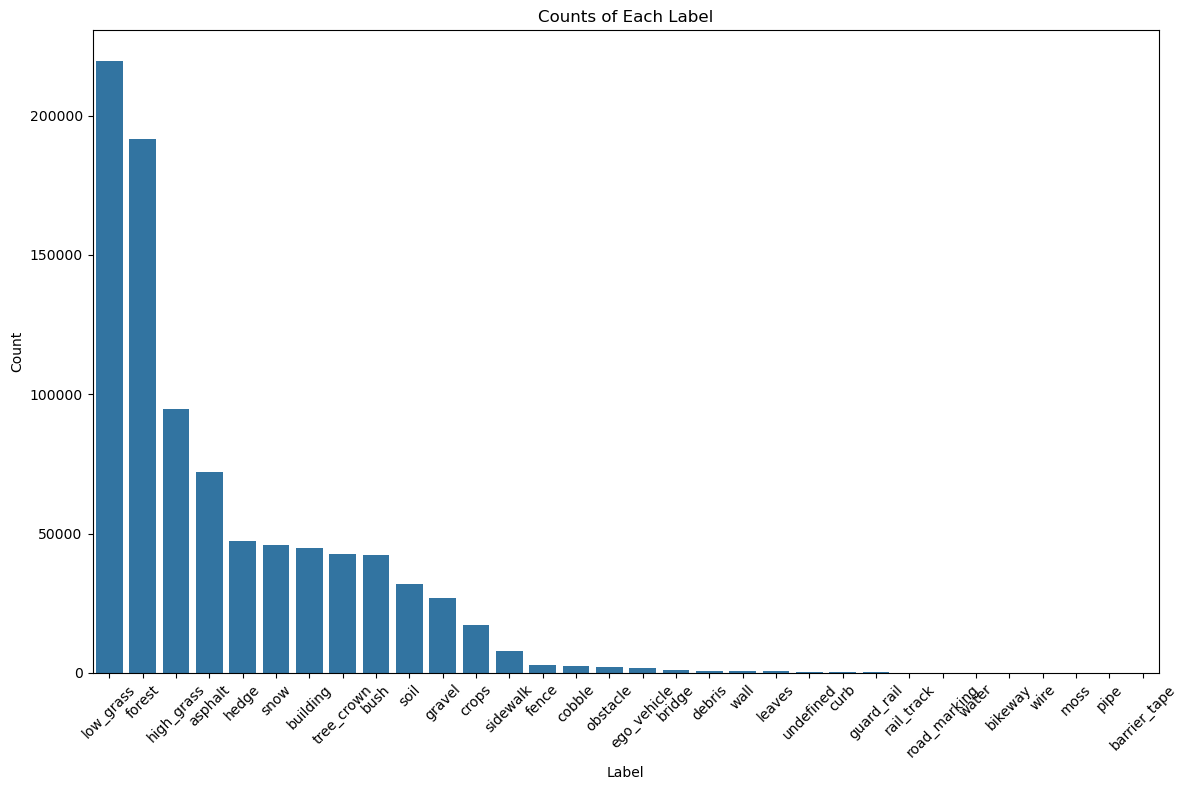

In [30]:
plt.figure(figsize=(12, 8))
sns.barplot(data=label_counts_df, x='Label', y='Count')
plt.xticks(rotation=45)
plt.title("Counts of Each Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


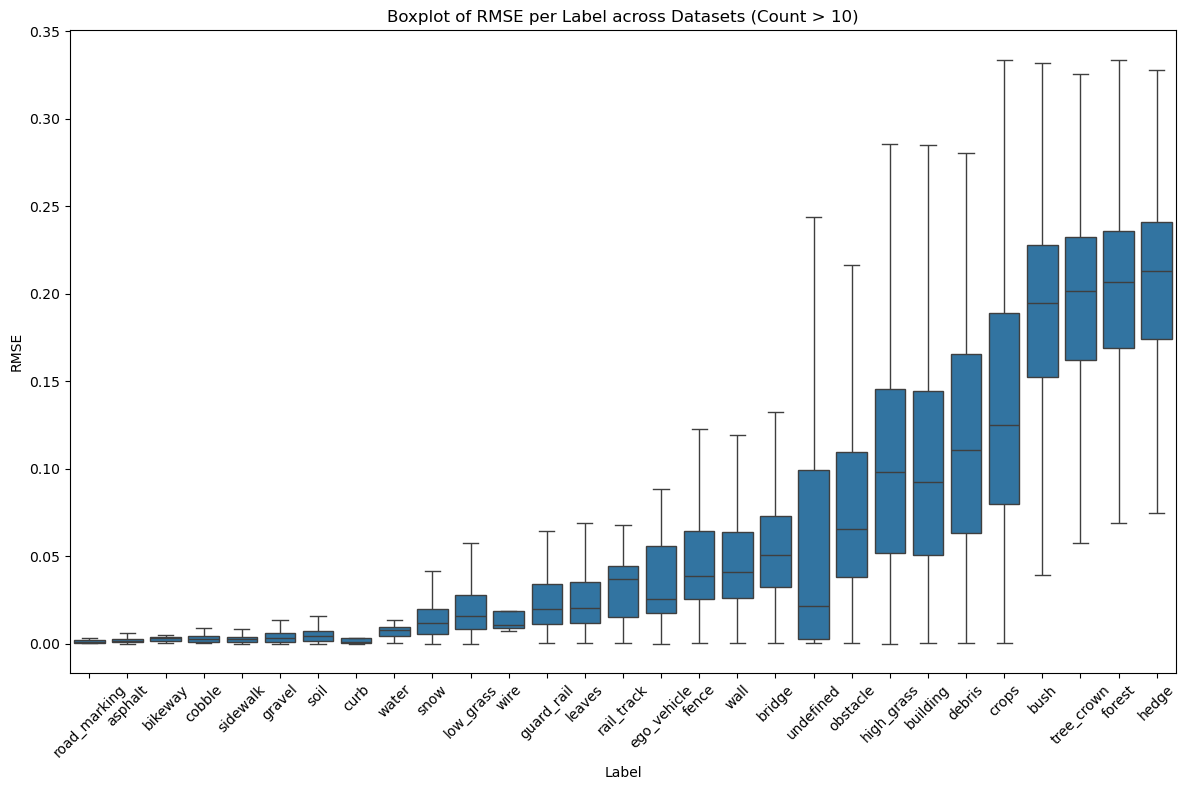

In [31]:
# Add label names based on dominant_label
voxel_df['dominant_label_name'] = voxel_df['dominant_label'].apply(lambda x: ih.get_label_name(x, metadata_map))

# Calculate counts of each label
label_counts = voxel_df['dominant_label_name'].value_counts()

# Filter for labels with count > 10
labels_with_sufficient_data = label_counts[label_counts > 10].index
filtered_df = voxel_df[voxel_df['dominant_label_name'].isin(labels_with_sufficient_data)]

# Calculate average RMSE per label for ordering
label_order = (
    filtered_df.groupby('dominant_label_name')['RMSE']
    .mean()
    .sort_values()
    .index
)

# Plot the ordered boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='dominant_label_name', y='RMSE', order=label_order, showfliers=False )
plt.xticks(rotation=45)
plt.title("Boxplot of RMSE per Label across Datasets (Count > 10)")
plt.xlabel("Label")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


INFO: Label metadata loaded successfully
INFO: Metadata map successfully created.


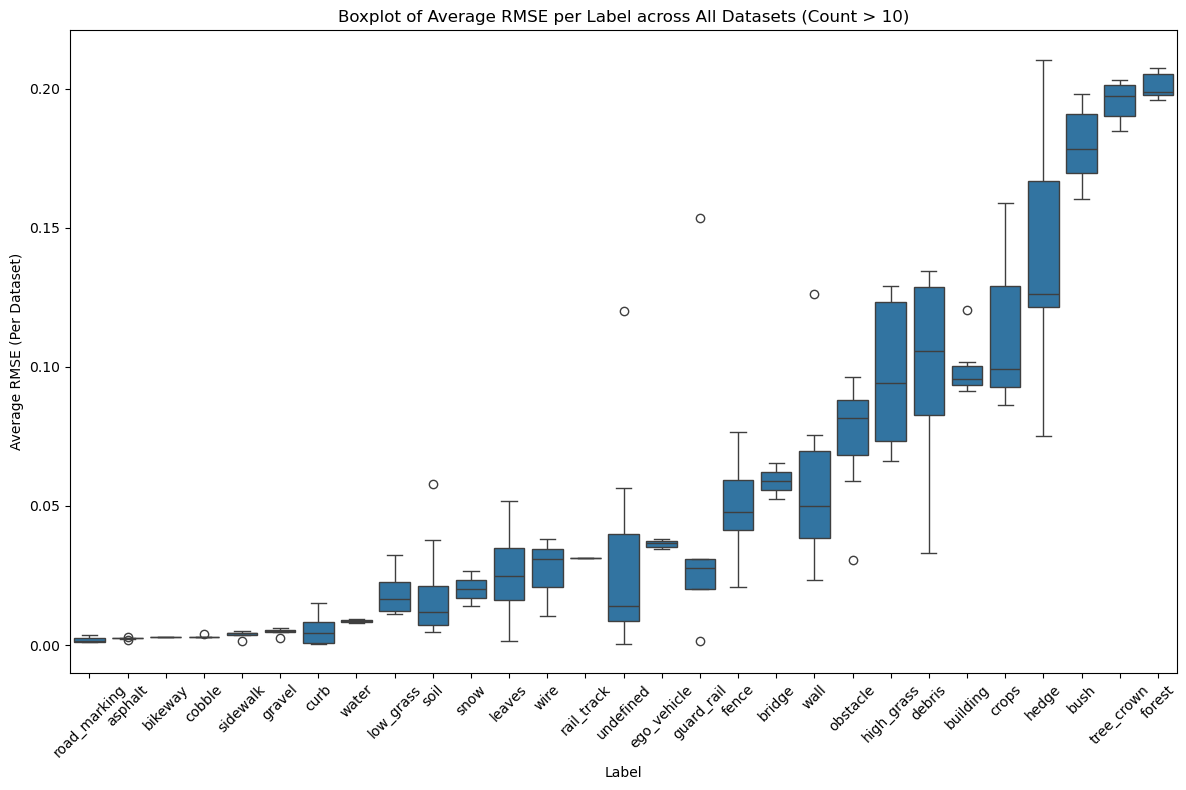

In [32]:
# Load metadata and create a map of label_key to label_name
metadata_map = ih.get_metadata_map(ih.load_label_metadata())

# Add label names based on dominant_label
voxel_df['dominant_label_name'] = voxel_df['dominant_label'].apply(lambda x: ih.get_label_name(x, metadata_map))

# Calculate counts of each label
label_counts = voxel_df['dominant_label_name'].value_counts()

# Filter for labels with count > 10
labels_with_sufficient_data = label_counts[label_counts > 10].index
filtered_df = voxel_df[voxel_df['dominant_label_name'].isin(labels_with_sufficient_data)]

# Calculate the average RMSE per label per dataset
average_rmse_per_label_dataset = (
    filtered_df.groupby(['dominant_label_name', 'dataset'])['RMSE']
    .mean()
    .reset_index()
)

# Order labels by their overall average RMSE for better visual clarity
label_order = (
    average_rmse_per_label_dataset.groupby('dominant_label_name')['RMSE']
    .mean()
    .sort_values()
    .index
)

# Plot the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=average_rmse_per_label_dataset, x='dominant_label_name', y='RMSE', order=label_order)
plt.xticks(rotation=45)
plt.title("Boxplot of Average RMSE per Label across All Datasets (Count > 10)")
plt.xlabel("Label")
plt.ylabel("Average RMSE (Per Dataset)")
plt.tight_layout()
plt.show()
